In [1]:
# !pip install torch
# !pip install torchvision 

In [2]:
import os
import xml.etree.ElementTree as ET
import torch
import numpy as np 
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from PIL import Image
from torchvision.ops import nms
from sklearn.metrics import precision_recall_curve, auc
import copy
import gc
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [3]:

# set direction and set parameters
data_dir = './Data/'
image_dir = os.path.join(data_dir, 'images')
label_dir = os.path.join(data_dir, 'xmls')
use_subset = False
sub_percentage = 0.1
train_batch_size = 30
test_batch_size = 1
step_size = 5
gamma = 0.5
lr = 0.001
weight_decay= 0.001
num_epochs = 30
nms_iou_thresh = 0.4
mAP_iou_threshold= 0.5
score_thresh = 0.2
num_classes = 5
patience = 5
num_worker = os.cpu_count()

In [4]:

# dataset class
class RDD2022Dataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.classes = ['Background', 'D00', 'D10', 'D20', 'D40']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        print(self.class_to_idx)

        self.images = list(sorted(os.listdir(image_dir)))
        self.labels = list(sorted(os.listdir(label_dir)))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # load image and label
        img_path = os.path.join(self.image_dir, self.images[idx])
        img = Image.open(img_path).convert("RGB")
        label_path = os.path.join(self.label_dir, self.labels[idx])
        tree = ET.parse(label_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.iter('object'):
            cls = obj.findtext('name')
            labels.append(self.class_to_idx[cls])
            xmlbox = obj.find('bndbox')
            bbox_coords = ['xmin', 'ymin', 'xmax', 'ymax']
            boxes.append([int(float(xmlbox.findtext(tag))) for tag in bbox_coords])
        # if have label
        if len(boxes) > 0:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # if it doesn't have label
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
            area = torch.zeros(0, dtype=torch.float32)

        image_id = torch.tensor([idx])
        iscrowd = torch.zeros(len(boxes), dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }
        if self.transforms:
            img, target = self.transforms(img, target)
        return img, target


In [5]:

def get_transform():
    def transform(img, target):
        img = F.to_tensor(img)
        return img, target
    return transform

def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Create dataset and data loader
train_dataset = RDD2022Dataset(
    os.path.join(image_dir, 'train'),
    os.path.join(label_dir, 'train'),
    transforms=get_transform()
)

val_dataset = RDD2022Dataset(
    os.path.join(image_dir, 'val'),
    os.path.join(label_dir, 'val'),
    transforms=get_transform()
)

def create_subset(dataset, subset_size):
    # Check subset condition
    if isinstance(subset_size, float) and subset_size > 0 and subset_size < 1:
        subset_size = int(len(dataset) * subset_size)
    elif isinstance(subset_size, int) and subset_size > 0 and subset_size < len(dataset):
        subset_size = subset_size
    else:
        raise ValueError("subset_size must be a positive integer or a float between 0 and 1.")
    # Generate a random subset
    indices = torch.randperm(len(dataset))[:subset_size]
    subset = Subset(dataset, indices)
    return subset

# DataLoader setup
# if using subset
if use_subset:
    train_subset_size = sub_percentage
    val_subset_size = sub_percentage
    train_subset = create_subset(train_dataset, train_subset_size)
    val_subset = create_subset(val_dataset, val_subset_size)
    train_loader = DataLoader(train_subset, batch_size=train_batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    val_loader = DataLoader(val_subset, batch_size=train_batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
    print('Using subset')
# if using full dataset
else:
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    val_loader = DataLoader(val_dataset, batch_size=train_batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
    print('Using full dataset')

# Clear CUDA cache
def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()


{'Background': 0, 'D00': 1, 'D10': 2, 'D20': 3, 'D40': 4}
{'Background': 0, 'D00': 1, 'D10': 2, 'D20': 3, 'D40': 4}
Using full dataset


In [6]:

# calculate Intersection over Union (IoU)
def calculate_iou(gt_box, pred_box):
    xi1 = max(gt_box[0], pred_box[0])
    yi1 = max(gt_box[1], pred_box[1])
    xi2 = min(gt_box[2], pred_box[2])
    yi2 = min(gt_box[3], pred_box[3])
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    gt_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    union_area = gt_area + pred_area - inter_area

    if union_area == 0:
        return 0
    iou = inter_area / union_area
    return iou

# apply Non-Max Suppression (NMS) to filter predictions
def apply_nms(orig_prediction, iou_thresh=nms_iou_thresh, score_thresh=score_thresh):
    # if no detections to process
    if orig_prediction['scores'].nelement() == 0:
        return {
            'boxes': torch.empty((0, 4), dtype=torch.float32),
            'scores': torch.empty((0,), dtype=torch.float32),
            'labels': torch.empty((0,), dtype=torch.int64)
        }
    # apply NMS
    boxes = orig_prediction['boxes'].float()
    scores = orig_prediction['scores'].float()
    high_score_mask = scores > score_thresh
    boxes = boxes[high_score_mask]
    scores = scores[high_score_mask]
    labels = orig_prediction['labels'][high_score_mask]
    keep = nms(boxes, scores, iou_thresh)
    return {'boxes': boxes[keep], 'scores': scores[keep],'labels': labels[keep]}

# update true positives, false positives, and false negatives for each class
def compute_tp_fp_fn_for_image(epoch_index, gt_boxes, gt_labels, pred_boxes, pred_scores, pred_labels, num_classes, iou_threshold= mAP_iou_threshold):
    # iterate through each class (ignoring the background class)
    for cls in range(1, num_classes):
        # filter ground truth and predictions for the current class
        gt_idx = np.where(gt_labels == cls)[0]
        pred_idx = np.where(pred_labels == cls)[0]

        if len(gt_idx) == 0 and len(pred_idx) == 0:
            continue
        elif len(gt_idx) == 0:
            epoch_index[cls-1,1] += len(pred_boxes[pred_idx])
            continue
        elif len(pred_idx) == 0:
            epoch_index[cls-1,2] += len(gt_boxes[gt_idx])
            continue

        class_gt_boxes = gt_boxes[gt_idx]
        class_pred_boxes = pred_boxes[pred_idx]
        class_pred_scores = pred_scores[pred_idx]

        # sort predictions by scores in descending order
        sorted_indices = np.argsort(-class_pred_scores)
        class_pred_boxes = class_pred_boxes[sorted_indices]

        # initialize counters for true positives, false positives, and false negatives
        tp = 0
        detected = np.zeros(len(class_gt_boxes), dtype=bool)

        # check each predicted box against all GT boxes of the same class
        for pred_box in class_pred_boxes:
            ious = [calculate_iou(pred_box, gt_box) for gt_box in class_gt_boxes]
            max_iou = max(ious)
            max_gt_idx = np.argmax(ious)

            if max_iou >= iou_threshold and not detected[max_gt_idx]:
                tp += 1
                detected[max_gt_idx] = True

        # update class metrics
        epoch_index[cls-1,0] += tp
        epoch_index[cls-1,1] += (len(class_pred_boxes) - tp)  # All non-TPs are FPs
        epoch_index[cls-1,2] += (len(class_gt_boxes) - np.sum(detected))  # GTs not detected are FNs

    return epoch_index


In [7]:

# evaluate the model and calculate mAP along with precision, recall, and F1 scores
def evaluate_or_test_model(model, data_loader, device):
    model.eval()
    # total_val_loss = 0
    epoch_index = np.zeros((num_classes-1, 3))
    all_detections = [[] for _ in range(num_classes-1)]
    all_annotations = [[] for _ in range(num_classes-1)]

    with torch.no_grad():
        # for each evaluation batch
        for images, targets in tqdm(data_loader, desc="Evaluating", leave=False):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)
            for i, output in enumerate(outputs):
                nms_output = apply_nms(output)
                pred_boxes = nms_output['boxes'].cpu().numpy()
                pred_labels = nms_output['labels'].cpu().numpy()
                pred_scores = nms_output['scores'].cpu().numpy()
                gt_boxes = targets[i]['boxes'].cpu().numpy()
                gt_labels = targets[i]['labels'].cpu().numpy()
                epoch_index = compute_tp_fp_fn_for_image(epoch_index, gt_boxes, gt_labels, pred_boxes, pred_scores, pred_labels, num_classes)

                # Store detections and annotations for mAP calculation
                for label in range(1, num_classes):
                    pred_indices = np.where(pred_labels == label)[0]
                    gt_indices = np.where(gt_labels == label)[0]
                    all_detections[label-1].extend([(box, score) for box, score in zip(pred_boxes[pred_indices], pred_scores[pred_indices])])
                    all_annotations[label-1].extend(gt_boxes[gt_indices])

            # Compute losses
            # if targets:
            #     model.train()
            #     loss_dict = model(images, targets)
            #     losses = sum(loss for loss in loss_dict.values())
            #     total_val_loss += losses.item()
            #     model.eval()

            del images, targets, outputs
            clear_memory()

    # avg_loss = total_val_loss / len(data_loader)

    # calculate mAP for each class
    avg_precisions = []
    for class_detections, class_annotations in zip(all_detections, all_annotations):
        if not class_detections or not class_annotations:
            continue
        # sort detections by decreasing confidence
        sorted_detections = sorted(class_detections, key=lambda x: x[1], reverse=True)
        tp = np.zeros(len(sorted_detections))
        fp = np.zeros(len(sorted_detections))
        matched = np.zeros(len(class_annotations), dtype=bool)  # Tracks which GT boxes have been matched

        for d_idx, (bbox, score) in enumerate(sorted_detections):
            ious = [calculate_iou(bbox, gt_bbox) for gt_bbox in class_annotations]
            best_iou = max(ious) if ious else 0
            best_idx = np.argmax(ious) if ious else -1

            if best_iou >= mAP_iou_threshold:
                if not matched[best_idx]:
                    tp[d_idx] = 1
                    matched[best_idx] = True
                else:
                    fp[d_idx] = 1
            else:
                fp[d_idx] = 1

        # accumulate true positives and false positives for precision-recall calculation
        acc_tp = np.cumsum(tp)
        acc_fp = np.cumsum(fp)
        recall = acc_tp / len(class_annotations) if len(class_annotations) > 0 else np.zeros_like(acc_tp)
        precision = acc_tp / (acc_tp + acc_fp) if (acc_tp + acc_fp).any() else np.zeros_like(acc_tp)

        # calculate area under the precision-recall curve (AUC)
        ap = auc(recall, precision)
        avg_precisions.append(ap)

    # compute the mean of average precisions across all classes
    mAP50 = np.mean(avg_precisions) if avg_precisions else 0

    # calculate overall precision, recall, and F1 score
    tp_total = epoch_index[:, 0]
    fp_total = epoch_index[:, 1]
    fn_total = epoch_index[:, 2]
    recall = tp_total / (tp_total + fn_total + 1e-6)
    precision = tp_total / (tp_total + fp_total + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

    # return avg_loss, mean_ap, precision, recall, f1_score

    return mAP50, precision, recall, f1_score


In [8]:

# train the model
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, patience=10):
    best_mAP50 = 0
    last_mAP50 = 0
    best_model_wts = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        total_train_loss = 0
        for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
            model.train()
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_train_loss += losses.item()
            losses.backward()
            optimizer.step()
            del images, targets, loss_dict
            clear_memory()
        mAP50, precision, recall, f1_score = evaluate_or_test_model(model, val_loader, device)
        # print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {total_train_loss/len(train_loader):.4f}, '
        #       f'Val Loss: {val_loss:.4f}, mAP: {mean_ap:.4f}')
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {total_train_loss/len(train_loader):.4f}, mAP50: {mAP50:.4f}')
        print(f'F1 per group: {f1_score}, Recall per group: {recall}, Precision per group: {precision}')
        print(f'General F1: {sum(f1_score) / len(f1_score)}, General Recall: {sum(recall) / len(recall)}, General Precision: {sum(precision) / len(precision)}')
        lr_scheduler.step()


        if mAP50 >= best_mAP50:
            best_mAP50 = mAP50
            last_mAP50 = mAP50
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        elif mAP50 >= last_mAP50:
            last_mAP50 = mAP50
            epochs_no_improve -= 1
        else:
            last_mAP50 = mAP50
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break
        clear_memory()

    model.load_state_dict(best_model_wts)
    return model, best_mAP50

# Initialize and train the model
model = get_model(len(train_dataset.classes))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
trained_model, best_mAP50 = train_model(model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs)


Epoch 1/30, Train Loss: 0.4162, mAP50: 0.3246
F1 per group: [0.33713641 0.28982113 0.28671805 0.10641862], Recall per group: [0.5262759  0.48695169 0.48803526 0.06481481], Precision per group: [0.24800571 0.2063044  0.20298586 0.29716981]
General F1: 0.2550235522946894, General Recall: 0.3915194172355834, General Precision: 0.2386164450470396


Epoch 2/30, Train Loss: 0.3621, mAP50: 0.4245
F1 per group: [0.36252282 0.32118479 0.36012322 0.2043614 ], Recall per group: [0.59095503 0.60188784 0.58690176 0.26028807], Precision per group: [0.26145763 0.21903415 0.25975474 0.16821808]
General F1: 0.31204805903169536, General Recall: 0.5100081739568955, General Precision: 0.2271161514685313


Epoch 3/30, Train Loss: 0.3457, mAP50: 0.4502
F1 per group: [0.34383799 0.34064398 0.3668366  0.22478695], Recall per group: [0.64502274 0.62520822 0.61020151 0.38065844], Precision per group: [0.23439221 0.23409563 0.26224628 0.15948276]
General F1: 0.3190263819198219, General Recall: 0.565272725669204, General Precision: 0.22255422143270737


Epoch 4/30, Train Loss: 0.3379, mAP50: 0.4764
F1 per group: [0.34167549 0.33547428 0.40245355 0.27522307], Recall per group: [0.6639717  0.65241532 0.61964735 0.44341564], Precision per group: [0.23002188 0.22578786 0.29800121 0.19953704]
General F1: 0.3387065981779748, General Recall: 0.5948625048367991, General Precision: 0.23833699637794364


Epoch 5/30, Train Loss: 0.3321, mAP50: 0.4824
F1 per group: [0.36303907 0.35330539 0.45079933 0.26356549], Recall per group: [0.67054068 0.66463076 0.58564232 0.47222222], Precision per group: [0.24889806 0.24060302 0.36643026 0.1827957 ]
General F1: 0.3576773212383736, General Recall: 0.5982589940019166, General Precision: 0.2596817581165475


Epoch 6/30, Train Loss: 0.3250, mAP50: 0.4938
F1 per group: [0.37829639 0.3462812  0.41217661 0.29027171], Recall per group: [0.66498231 0.66574125 0.64798489 0.47736625], Precision per group: [0.26433665 0.23399688 0.30220264 0.20853933]
General F1: 0.35675647975779323, General Recall: 0.6140186773789105, General Precision: 0.25226887344598103


Epoch 7/30, Train Loss: 0.3228, mAP50: 0.5038
F1 per group: [0.38561904 0.35463033 0.40155831 0.27530098], Recall per group: [0.65310763 0.67184897 0.6813602  0.50514403], Precision per group: [0.27357392 0.2408919  0.28466193 0.18921002]
General F1: 0.35427716370113677, General Recall: 0.6278652089638609, General Precision: 0.24708444263822435


Epoch 8/30, Train Loss: 0.3200, mAP50: 0.5054
F1 per group: [0.37985179 0.3598877  0.4066688  0.26866446], Recall per group: [0.66877211 0.67851194 0.66813602 0.50720165], Precision per group: [0.26525704 0.24488978 0.2922865  0.18272795]
General F1: 0.3537681853802731, General Recall: 0.6306554274226359, General Precision: 0.2462903167808252


Epoch 9/30, Train Loss: 0.3184, mAP50: 0.5017
F1 per group: [0.39588417 0.39562193 0.42349573 0.31858952], Recall per group: [0.67079333 0.67240422 0.66057934 0.49279835], Precision per group: [0.28080381 0.2802592  0.31164587 0.23538084]
General F1: 0.38339783792939053, General Recall: 0.6241438118435739, General Precision: 0.2770224280790272


Epoch 10/30, Train Loss: 0.3153, mAP50: 0.5114
F1 per group: [0.38194058 0.37608386 0.4081241  0.30706394], Recall per group: [0.67862557 0.67406996 0.67695214 0.50308642], Precision per group: [0.26575641 0.26079484 0.29211957 0.22096701]
General F1: 0.3683031220335808, General Recall: 0.6331835222307615, General Precision: 0.25990945719117275


Epoch 11/30, Train Loss: 0.3127, mAP50: 0.5098
F1 per group: [0.38872384 0.37101409 0.44911172 0.28376123], Recall per group: [0.67938353 0.67518045 0.65302267 0.53395062], Precision per group: [0.27224866 0.2557846  0.34224422 0.19322413]
General F1: 0.37315272049669523, General Recall: 0.6353843170346273, General Precision: 0.26587540254721376


Epoch 12/30, Train Loss: 0.3110, mAP50: 0.5135
F1 per group: [0.39329893 0.36645549 0.45470263 0.28404305], Recall per group: [0.68216271 0.6757357  0.66057934 0.52469136], Precision per group: [0.27629963 0.25139434 0.34666226 0.19473081]
General F1: 0.37462502460779795, General Recall: 0.6357922781089205, General Precision: 0.26727176126026553


Epoch 13/30, Train Loss: 0.3095, mAP50: 0.5192
F1 per group: [0.38590707 0.35935417 0.43071944 0.31122406], Recall per group: [0.68494189 0.6862854  0.67632242 0.50205761], Precision per group: [0.26862862 0.24340291 0.31597529 0.22550832]
General F1: 0.37180118463437645, General Recall: 0.6374018291633097, General Precision: 0.26337878394162806


Epoch 14/30, Train Loss: 0.3085, mAP50: 0.5203
F1 per group: [0.38841406 0.37546313 0.42964423 0.25462169], Recall per group: [0.68948964 0.67462521 0.66624685 0.55967078], Precision per group: [0.27035863 0.26011561 0.31705124 0.16479855]
General F1: 0.3620357790127815, General Recall: 0.6475081202962171, General Precision: 0.25308100628116165


Epoch 15/30, Train Loss: 0.3073, mAP50: 0.5210
F1 per group: [0.39611102 0.37050429 0.45772613 0.30632792], Recall per group: [0.68974229 0.68073293 0.66309824 0.5154321 ], Precision per group: [0.27783432 0.25451526 0.34948556 0.21792084]
General F1: 0.3826673407582427, General Recall: 0.6372513885703057, General Precision: 0.2749389932483811


Epoch 16/30, Train Loss: 0.3056, mAP50: 0.5179
F1 per group: [0.40959396 0.38266442 0.44917918 0.30343528], Recall per group: [0.6773623  0.69128262 0.66372796 0.51337449], Precision per group: [0.29355086 0.26455589 0.3394525  0.2153647 ]
General F1: 0.38621820934667117, General Recall: 0.6364368421884052, General Precision: 0.27823098425852594


Epoch 17/30, Train Loss: 0.3053, mAP50: 0.5236
F1 per group: [0.40538477 0.38030937 0.45017137 0.30034482], Recall per group: [0.68468924 0.68850638 0.65994962 0.53703704], Precision per group: [0.2879303  0.26271186 0.34159061 0.20846645]
General F1: 0.3840525838400366, General Recall: 0.6425455700024415, General Precision: 0.27517480807989164


Epoch 18/30, Train Loss: 0.3043, mAP50: 0.5243
F1 per group: [0.39417491 0.38244764 0.44269059 0.28970878], Recall per group: [0.69075291 0.68961688 0.67128463 0.53292181], Precision per group: [0.27577164 0.2645931  0.33023544 0.19892473]
General F1: 0.37725547731761955, General Recall: 0.6461440572377708, General Precision: 0.2673812261155886


Epoch 19/30, Train Loss: 0.3035, mAP50: 0.5290
F1 per group: [0.40038245 0.37583243 0.43443076 0.29566139], Recall per group: [0.68696311 0.68906163 0.67695214 0.55041152], Precision per group: [0.28252286 0.25838018 0.31984528 0.2021156 ]
General F1: 0.37657675815153563, General Recall: 0.6508471018131401, General Precision: 0.265715981257132


Epoch 20/30, Train Loss: 0.3028, mAP50: 0.5243
F1 per group: [0.40014611 0.39230111 0.44256154 0.30433494], Recall per group: [0.68999495 0.67906718 0.67443325 0.54526749], Precision per group: [0.28177879 0.27582318 0.32933579 0.21107129]
General F1: 0.38483592598648164, General Recall: 0.6471907173463327, General Precision: 0.27450226263327754


Epoch 21/30, Train Loss: 0.3022, mAP50: 0.5233
F1 per group: [0.4071148  0.38390053 0.43810262 0.30810932], Recall per group: [0.69100556 0.68850638 0.67191436 0.52572016], Precision per group: [0.28856299 0.26615153 0.32500761 0.21791045]
General F1: 0.3843068165541467, General Recall: 0.6442866161187749, General Precision: 0.27440814627605736


Epoch 22/30, Train Loss: 0.3017, mAP50: 0.5272
F1 per group: [0.39658716 0.37904664 0.44496642 0.29965713], Recall per group: [0.6988378  0.68906163 0.65554156 0.54012346], Precision per group: [0.27684916 0.26142827 0.33678421 0.20734597]
General F1: 0.3800643396693183, General Recall: 0.6458911115672122, General Precision: 0.2706019045634626


Epoch 23/30, Train Loss: 0.3014, mAP50: 0.5248
F1 per group: [0.41608136 0.38829412 0.44260897 0.31206065], Recall per group: [0.68898434 0.6851749  0.67506297 0.52572016], Precision per group: [0.29803279 0.27091109 0.32923833 0.2218845 ]
General F1: 0.3897612757541581, General Recall: 0.6437355934338785, General Precision: 0.28001667525804996


Epoch 24/30, Train Loss: 0.3014, mAP50: 0.5230
F1 per group: [0.40342419 0.37942082 0.45165432 0.30677723], Recall per group: [0.69050025 0.68795114 0.65743073 0.5308642 ], Precision per group: [0.28495464 0.26194503 0.34398682 0.21571906]
General F1: 0.3853191421627101, General Recall: 0.6416865793505593, General Precision: 0.27665139009425377


Epoch 25/30, Train Loss: 0.3006, mAP50: 0.5234
F1 per group: [0.411056   0.39218759 0.44625635 0.30979043], Recall per group: [0.68569985 0.68573015 0.67191436 0.52572016], Precision per group: [0.29350059 0.27462753 0.33406387 0.21959605]
General F1: 0.3898225920659566, General Recall: 0.6422661297746738, General Precision: 0.2804470100318245


Epoch 26/30, Train Loss: 0.3001, mAP50: 0.5263
F1 per group: [0.4072994  0.37543344 0.44393261 0.30110618], Recall per group: [0.69075291 0.69072737 0.66813602 0.531893  ], Precision per group: [0.28879265 0.25777041 0.33239348 0.20999188]
General F1: 0.3819429047483732, General Recall: 0.6453773254823699, General Precision: 0.2722371045957338


Epoch 27/30, Train Loss: 0.2999, mAP50: 0.5253
F1 per group: [0.40933612 0.37875037 0.45088385 0.30783037], Recall per group: [0.68898434 0.68684064 0.66624685 0.52777778], Precision per group: [0.29115951 0.26146692 0.34074074 0.21728081]
General F1: 0.386700175344605, General Recall: 0.6424624018137014, General Precision: 0.27766199677819897


Epoch 28/30, Train Loss: 0.2999, mAP50: 0.5241
F1 per group: [0.41638549 0.3820465  0.45083989 0.31002078], Recall per group: [0.68696311 0.68295391 0.67569269 0.52674897], Precision per group: [0.29872555 0.26520052 0.33827238 0.21964822]
General F1: 0.38982316398672645, General Recall: 0.6430896730156126, General Precision: 0.2804616687498095


Epoch 29/30, Train Loss: 0.2996, mAP50: 0.5244
F1 per group: [0.41007583 0.37897609 0.4492536  0.30535204], Recall per group: [0.69302678 0.68461966 0.6731738  0.53703704], Precision per group: [0.29118896 0.26200595 0.33711763 0.21332244]
General F1: 0.3859143873707298, General Recall: 0.646964318995318, General Precision: 0.27590874334382587


Epoch 30/30, Train Loss: 0.2993, mAP50: 0.5273
F1 per group: [0.41407636 0.38740955 0.45406052 0.31197056], Recall per group: [0.68671046 0.68684064 0.67065491 0.5308642 ], Precision per group: [0.29640131 0.2697928  0.34321624 0.22089041]
General F1: 0.391879249855997, General Recall: 0.6437675529402802, General Precision: 0.2825751910602418


In [9]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")
save_model_path = f'./faster_rcnn_lr{lr}_bs{train_batch_size}_epochs{num_epochs}_mAP{best_mAP50}_stable.pth'
# Example usage:
model_save_path = save_model_path
save_model(trained_model, model_save_path)


Model saved to ./faster_rcnn_lr0.001_bs30_epochs30_mAP0.529027792937071_stable.pth


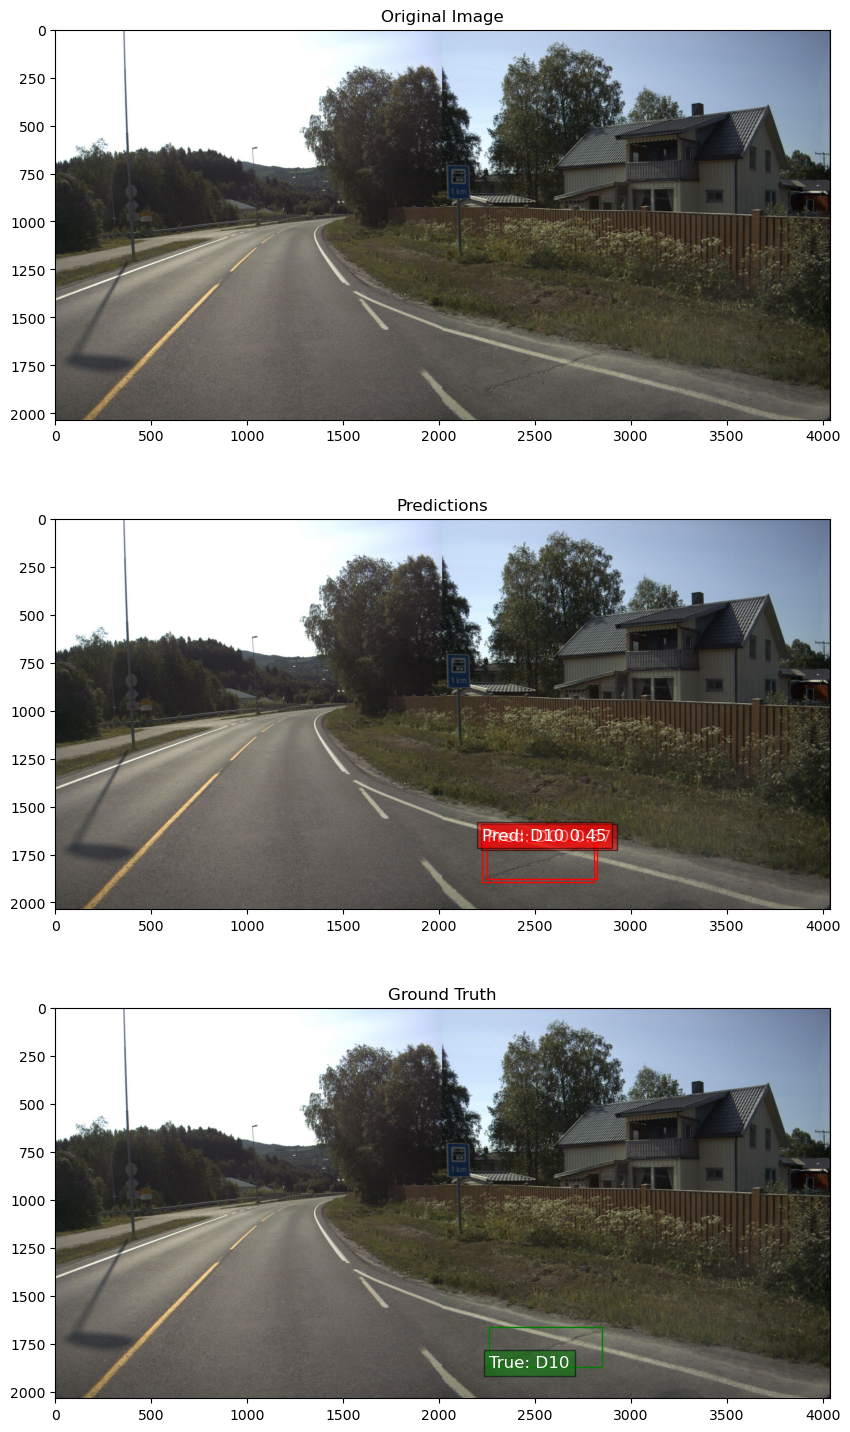

In [10]:
def visualize_comparison_three_plots(image_path, label_path, model, device, dataset_classes, transform=None):
    # Load and prepare image
    image = Image.open(image_path).convert("RGB")
    if transform:
        image_tensor, _ = transform(image, {})  # Assuming the transform function returns a tensor and a target
    else:
        image_tensor = F.to_tensor(image)  # Convert to tensor without any additional transformation

    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension and transfer to device

    # Load true labels and boxes
    tree = ET.parse(label_path)
    root = tree.getroot()
    true_boxes = []
    true_labels = []
    for obj in root.iter('object'):
        cls = obj.find('name').text
        xmlbox = obj.find('bndbox')
        xmin = int(float(xmlbox.find('xmin').text))
        ymin = int(float(xmlbox.find('ymin').text))
        xmax = int(float(xmlbox.find('xmax').text))
        ymax = int(float(xmlbox.find('ymax').text))
        true_boxes.append([xmin, ymin, xmax, ymax])
        true_labels.append(dataset_classes.index(cls))

    # Model inference
    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)
    predictions = apply_nms(predictions[0], 30)  # Assuming apply_nms is defined correctly

    # Prepare image for plotting
    image_np = np.array(image)

    # Set up three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))
    ax1.imshow(image_np)
    ax2.imshow(image_np)
    ax3.imshow(image_np)

    # Draw predicted boxes and labels on the second subplot
    pred_boxes = predictions['boxes'].cpu().numpy()
    pred_scores = predictions['scores'].cpu().numpy()
    pred_labels = predictions['labels'].cpu().numpy()

    for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax2.add_patch(rect)
        ax2.text(x1, y1, f'Pred: {dataset_classes[label]} {score:.2f}', color='white', fontsize=12,
                 bbox=dict(facecolor='red', alpha=0.5))

    # Draw true boxes and labels on the third subplot
    for box, label in zip(true_boxes, true_labels):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='g', facecolor='none')
        ax3.add_patch(rect)
        ax3.text(x1, y2, f'True: {dataset_classes[label]}', color='white', fontsize=12,
                 bbox=dict(facecolor='green', alpha=0.5))

    ax1.set_title('Original Image')
    ax2.set_title('Predictions')
    ax3.set_title('Ground Truth')
    plt.show()

# Example usage
image_path = './Data/images/val/Norway_000830.jpg'
label_path = './Data/xmls/val/Norway_000830.xml'
visualize_comparison_three_plots(image_path, label_path, model, device, train_dataset.classes, transform=get_transform())


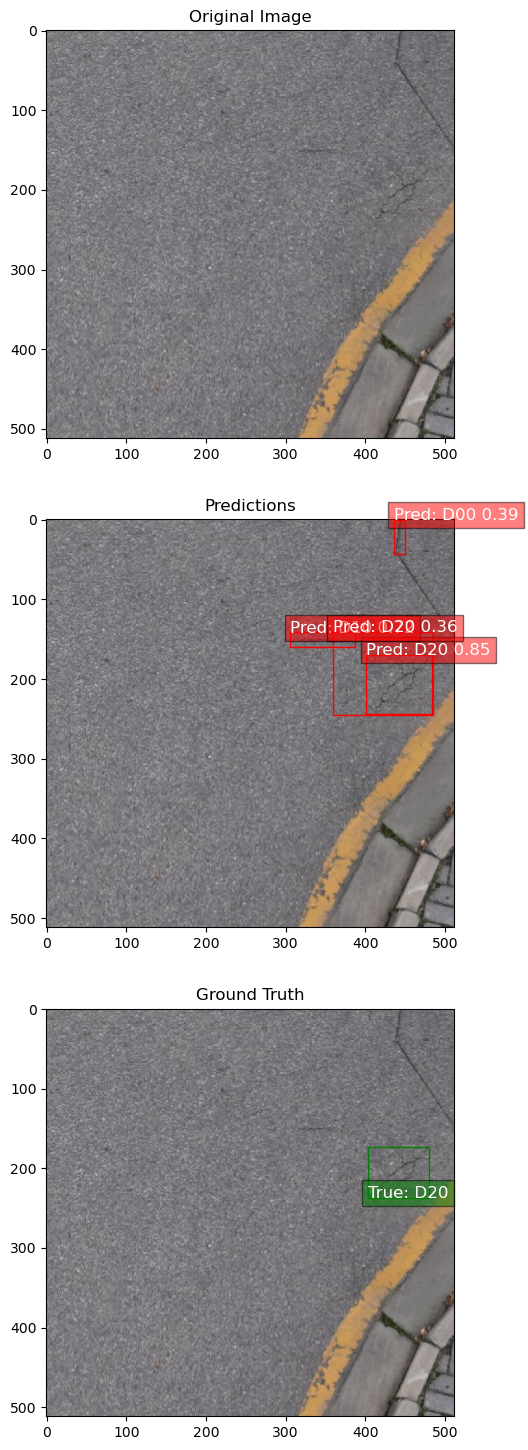

In [11]:
# Example usage
image_path = './Data/images/val/China_Drone_000086.jpg'
label_path = './Data/xmls/val/China_Drone_000086.xml'
visualize_comparison_three_plots(image_path, label_path, model, device, train_dataset.classes, transform=get_transform())


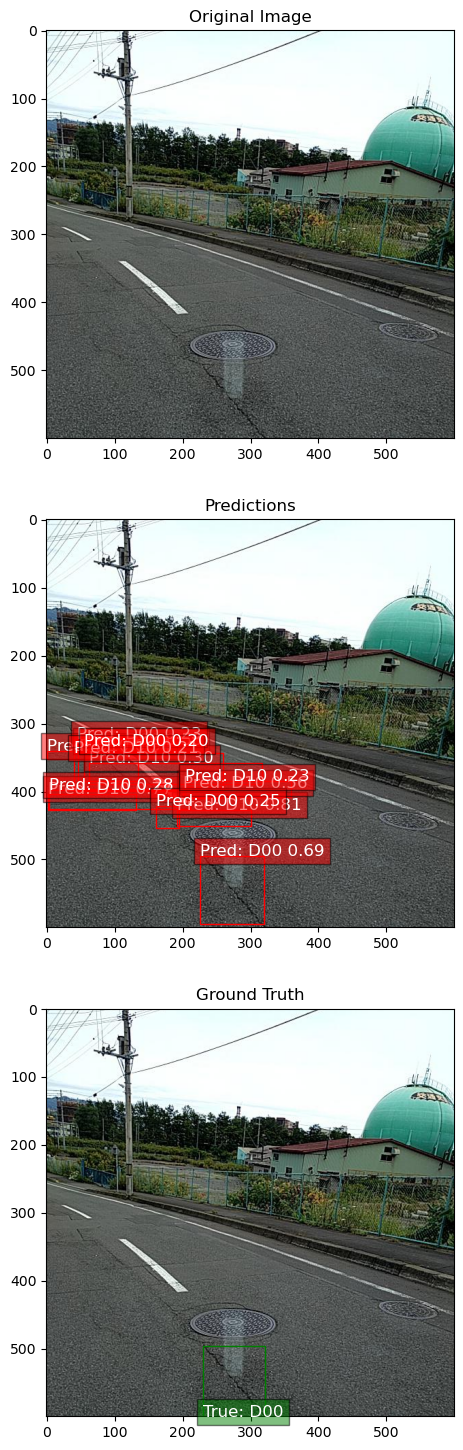

In [12]:
# Example usage
image_path = './Data/images/val/Japan_003127.jpg'
label_path = './Data/xmls/val/Japan_003127.xml'
visualize_comparison_three_plots(image_path, label_path, model, device, train_dataset.classes, transform=get_transform())


In [14]:
import os
import torch
import xml.etree.ElementTree as ET
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as F
from PIL import Image
local_model_path = f'./faster_rcnn_lr{lr}_bs{train_batch_size}_epochs{num_epochs}_mAP{best_mAP50}_stable.pth'
test_image_dir = os.path.join(image_dir, 'test')
test_label_dir = os.path.join(label_dir, 'test')
model_path = local_model_path
test_batch_size = 4

class TestDataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.images = list(sorted(os.listdir(image_dir)))
        self.labels = list(sorted(os.listdir(label_dir)))
        self.class_to_idx = {'Background': 0, 'D00': 1, 'D10': 2, 'D20': 3, 'D40': 4}  # Update as necessary

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.labels[idx])
        img = Image.open(img_path).convert("RGB")

        tree = ET.parse(label_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.iter('object'):
            cls = obj.findtext('name')
            labels.append(self.class_to_idx[cls])
            xmlbox = obj.find('bndbox')
            boxes.append([int(xmlbox.findtext(tag)) for tag in ['xmin', 'ymin', 'xmax', 'ymax']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros(0, dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if boxes.nelement() != 0 else torch.zeros(0, dtype=torch.float32)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([idx]), 'area': area, 'iscrowd': torch.zeros(len(boxes), dtype=torch.int64)}

        if self.transforms:
            img = self.transforms(img)

        return img, target

def get_transform():
    def transform(img):
        return F.to_tensor(img)
    return transform

# Load the model
def load_model(model_path, num_classes):
    model = get_model(num_classes)  # Ensure get_model is defined or imported
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

test_dataset = TestDataset(test_image_dir, test_label_dir, transforms=get_transform())
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

model = load_model(model_path, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mean_ap, precision, recall, f1_score = evaluate_or_test_model(model, test_loader, device)
print(f'Test mAP50: {mean_ap:.4f}')
print(f'F1 per group: {f1_score}, Recall per group: {recall}, Precision per group: {precision}')
print(f'General F1: {sum(f1_score) / len(f1_score)}, General Recall: {sum(recall) / len(recall)}, General Precision: {sum(precision) / len(precision)}')


Test mAP50: 0.5255
F1 per group: [0.39987477 0.35655071 0.44426219 0.30079416], Recall per group: [0.67447368 0.68961424 0.68908629 0.56084656], Precision per group: [0.28417785 0.24043037 0.32779958 0.20550601]
General F1: 0.37537045655045453, General Recall: 0.6535051952948219, General Precision: 0.2644784521300849
